In [1]:

import numpy as np
import pandas as pd
import missingno as msno
from scipy import stats
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

In [2]:

#Завантажуємо вихідні файли (перша сторінка кожного файлу) з БД CALCE, що містять дані для визначення шуканих
# індикаторів здоров'я

#Назва вілповідає даті створення таблиці в базі(місяць_день)
data1_10 = pd.read_excel('C:/Users/gorob/CS2_33/CS2_33_1_10_11.xlsx', sheet_name = 'Channel_1-006' )
data1_18 = pd.read_excel('C:/Users/gorob/CS2_33/CS2_33_1_18_11.xlsx', sheet_name = 'Channel_1-006' )
data1_24 = pd.read_excel('C:/Users/gorob/CS2_33/CS2_33_1_24_11.xlsx', sheet_name = 'Channel_1-006' )
data1_28 = pd.read_excel('C:/Users/gorob/CS2_33/CS2_33_1_28_11.xlsx', sheet_name = 'Channel_1-006' )
data2_2 = pd.read_excel('C:/Users/gorob/CS2_33/CS2_33_2_2_11.xlsx', sheet_name = 'Channel_1-006' )
# Змінюємо номера циклів для поєднання в один спільний файл
data1_18['Cycle_Index'] = data1_18['Cycle_Index']+50
data1_24['Cycle_Index'] = data1_24['Cycle_Index']+100
data1_28['Cycle_Index']= data1_28['Cycle_Index']+150
data2_2['Cycle_Index'] = data2_2['Cycle_Index']+200
#Створюємо один спльний файл з 250 циклами та видаляємо непотрібні стовпці
data = pd.concat([data1_10,data1_18,data1_24, data1_28,data2_2], ignore_index = True)
data.drop(['Charge_Energy(Wh)', 'Discharge_Energy(Wh)','dV/dt(V/s)','Internal_Resistance(Ohm)','Is_FC_Data','AC_Impedance(Ohm)','ACI_Phase_Angle(Deg)'], axis= 1 , inplace= True )
#Завантажуємо вихідні файли (друга сторінка кожного файлу) з БД CALCE,що містять дані енергоємності
stat1_10 = pd.read_excel('C:/Users/gorob/CS2_33/CS2_33_1_10_11.xlsx', sheet_name = 'Statistics_1-006' )
stat1_18 = pd.read_excel('C:/Users/gorob/CS2_33/CS2_33_1_18_11.xlsx', sheet_name = 'Statistics_1-006' )
stat1_24 = pd.read_excel('C:/Users/gorob/CS2_33/CS2_33_1_24_11.xlsx', sheet_name = 'Statistics_1-006' )
stat1_28 = pd.read_excel('C:/Users/gorob/CS2_33/CS2_33_1_28_11.xlsx', sheet_name = 'Statistics_1-006' )
stat2_2 = pd.read_excel('C:/Users/gorob/CS2_33/CS2_33_2_2_11.xlsx', sheet_name = 'Statistics_1-006' )
st10=stat1_10['Discharge_Capacity(Ah)'].diff()
st18=stat1_18['Discharge_Capacity(Ah)'].diff()
st24=stat1_24['Discharge_Capacity(Ah)'].diff()
st28=stat1_28['Discharge_Capacity(Ah)'].diff()
st2=stat2_2['Discharge_Capacity(Ah)'].diff()
# 1.1 A nominal charge 1.1
soh=np.round(pd.concat([st10, st18,st24,st28,st2 ], ignore_index = True)/1.1, 1)
soh.loc[0]=0.9
soh.loc[50]=0.7
soh.loc[100]=0.6
soh.loc[150]=0.4
soh.loc[200]=0.2




In [3]:
soh.info()

<class 'pandas.core.series.Series'>
RangeIndex: 250 entries, 0 to 249
Series name: Discharge_Capacity(Ah)
Non-Null Count  Dtype  
--------------  -----  
250 non-null    float64
dtypes: float64(1)
memory usage: 2.1 KB


In [4]:
soh.describe()

count    250.000000
mean       0.388000
std        0.215504
min        0.000000
25%        0.200000
50%        0.400000
75%        0.600000
max        0.900000
Name: Discharge_Capacity(Ah), dtype: float64

In [5]:
soh.isnull()

0      False
1      False
2      False
3      False
4      False
       ...  
245    False
246    False
247    False
248    False
249    False
Name: Discharge_Capacity(Ah), Length: 250, dtype: bool

In [15]:
soh = pd.DataFrame(data=soh)

In [17]:
soh['c']=np.where(soh['Discharge_Capacity(Ah)'] >= 0.8,0,1)
soh.head()

,Discharge_Capacity(Ah),c
0,0.9,0
1,0.8,0
2,0.8,0
3,0.8,0
4,0.8,0


In [23]:
soh.drop(['Discharge_Capacity(Ah)'], axis=1)

,c,cycle
0,0,0
1,0,1
2,0,2
3,0,3
4,0,4
...,...,...
245,1,245
246,1,246
247,1,247
248,1,248


In [25]:
soh['cycle']=range(0,250)

In [27]:
soh.head()

,Discharge_Capacity(Ah),c,cycle
0,0.9,0,0
1,0.8,0,1
2,0.8,0,2
3,0.8,0,3
4,0.8,0,4


In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46682 entries, 0 to 46681
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Data_Point              46682 non-null  int64         
 1   Test_Time(s)            46682 non-null  float64       
 2   Date_Time               46682 non-null  datetime64[ns]
 3   Step_Time(s)            46682 non-null  float64       
 4   Step_Index              46682 non-null  int64         
 5   Cycle_Index             46682 non-null  int64         
 6   Current(A)              46682 non-null  float64       
 7   Voltage(V)              46682 non-null  float64       
 8   Charge_Capacity(Ah)     46682 non-null  float64       
 9   Discharge_Capacity(Ah)  46682 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int64(3)
memory usage: 3.6 MB


In [31]:
data.head()

,Data_Point,Test_Time(s),Date_Time,Step_Time(s),Step_Index,Cycle_Index,Current(A),Voltage(V),Charge_Capacity(Ah),Discharge_Capacity(Ah)
0,1,30.000402,2011-01-03 10:38:25,30.000402,1,1,0.000000,4.118745,0.000000,0.0
1,2,60.015662,2011-01-03 10:38:55,60.015662,1,1,0.000000,4.118745,0.000000,0.0
2,3,90.030747,2011-01-03 10:39:25,90.030747,1,1,0.000000,4.118907,0.000000,0.0
3,4,120.014300,2011-01-03 10:39:55,120.014301,1,1,0.000000,4.118745,0.000000,0.0
4,5,137.905777,2011-01-03 10:40:13,17.890985,2,1,0.549845,4.200065,0.002732,0.0


In [33]:
data_reg = data.copy()
data_reg = pd.DataFrame(data = data_reg.drop(['Data_Point','Date_Time','Step_Time(s)','Charge_Capacity(Ah)','Discharge_Capacity(Ah)','Current(A)'], axis =1))

In [35]:
data_reg.head()

,Test_Time(s),Step_Index,Cycle_Index,Voltage(V)
0,30.000402,1,1,4.118745
1,60.015662,1,1,4.118745
2,90.030747,1,1,4.118907
3,120.014300,1,1,4.118745
4,137.905777,2,1,4.200065


In [37]:
data_reg = data_reg.loc[data_reg['Step_Index']==2].drop(['Step_Index'], axis=1)

In [39]:
data_reg.info()
data_reg.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 14491 entries, 4 to 46653
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Test_Time(s)  14491 non-null  float64
 1   Cycle_Index   14491 non-null  int64  
 2   Voltage(V)    14491 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 452.8 KB


,Test_Time(s),Cycle_Index,Voltage(V)
count,14491.000000,14491.000000,14491.000000
mean,251422.536454,72.963150,4.043375
std,165900.354694,51.703859,0.101142
min,137.905777,1.000000,3.609444
25%,108327.233355,31.000000,3.972143
50%,229529.911101,64.000000,4.050385
75%,383966.388993,105.000000,4.127007
max,601026.115720,250.000000,4.200227


In [42]:
voltages = [ v for v in np.arange(data_reg['Voltage(V)'].min(), data_reg['Voltage(V)'].max(), 0.05)]
np.round(voltages,3)

array([3.609, 3.659, 3.709, 3.759, 3.809, 3.859, 3.909, 3.959, 4.009,
       4.059, 4.109, 4.159])

In [44]:
for v in range(len(voltages)):
    data_values = data_reg.loc[np.round(data_reg['Voltage(V)'],2)==np.round(voltages,2)[v]]
    print(f'{v}[{np.round(voltages[v],2)}]: {len(data_values['Cycle_Index'].unique())}')

0[3.61]: 1
1[3.66]: 0
2[3.71]: 0
3[3.76]: 13
4[3.81]: 57
5[3.86]: 95
6[3.91]: 140
7[3.96]: 153
8[4.01]: 169
9[4.06]: 192
10[4.11]: 199
11[4.16]: 220


In [46]:
volt_arr = [(3.91, 3.96),(3.96, 4.01),(4.01, 4.06),(4.06, 4.11),(4.11, 4.16)]

In [48]:
soh.head()

,Discharge_Capacity(Ah),c,cycle
0,0.9,0,0
1,0.8,0,1
2,0.8,0,2
3,0.8,0,3
4,0.8,0,4


In [50]:
df_time_diff = pd.DataFrame({'cycle': range(0,250)})

In [52]:
for c in range(0,250):
    cycle = data_reg.loc[data_reg['Cycle_Index']==c]
    for v in volt_arr:
      time_1 = cycle.loc[np.round(data_reg['Voltage(V)'],2)==v[0], ['Test_Time(s)']].values
      time_2 = cycle.loc[np.round(data_reg['Voltage(V)'],2)==v[1], ['Test_Time(s)']].values
      if time_1.size!=0 and time_2.size!=0:
         time = time_2.max()-time_1.max()
         df_time_diff.loc[df_time_diff['cycle']==c, [f'volt_{v}']]=time
         df_time_diff.loc[df_time_diff['cycle']==c, [f'soh']]=soh.loc[soh['cycle']==c, ['c']].values

In [54]:
df_time_diff.describe()

,cycle,"volt_(3.91, 3.96)",soh,"volt_(3.96, 4.01)","volt_(4.01, 4.06)","volt_(4.06, 4.11)","volt_(4.11, 4.16)"
count,250.000000,137.000000,198.000000,151.000000,168.000000,188.000000,198.000000
mean,124.500000,346.597212,0.984848,420.011507,416.279771,366.087403,342.292761
std,72.312977,168.536620,0.122465,183.411063,167.248037,138.709793,102.862602
min,0.000000,90.045150,0.000000,60.030000,60.030066,60.030327,60.030232
25%,62.250000,180.090868,1.000000,225.112759,240.121157,270.135963,270.135982
50%,124.500000,390.196381,1.000000,450.226749,450.226678,420.211599,390.196353
75%,186.750000,450.227115,1.000000,570.287576,570.287551,480.242378,420.212010
max,249.000000,840.427828,1.000000,750.383193,630.319561,540.274392,450.229083


In [56]:
df_time_diff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   cycle              250 non-null    int64  
 1   volt_(3.91, 3.96)  137 non-null    float64
 2   soh                198 non-null    float64
 3   volt_(3.96, 4.01)  151 non-null    float64
 4   volt_(4.01, 4.06)  168 non-null    float64
 5   volt_(4.06, 4.11)  188 non-null    float64
 6   volt_(4.11, 4.16)  198 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 13.8 KB


In [58]:
df_time_diff.head()

,cycle,"volt_(3.91, 3.96)",soh,"volt_(3.96, 4.01)","volt_(4.01, 4.06)","volt_(4.06, 4.11)","volt_(4.11, 4.16)"
0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,NaN,NaN,NaN,NaN,NaN
2,2,840.427828,0.0,720.369000,570.288087,480.244365,420.214257
3,3,780.377010,0.0,750.378730,600.303152,510.257500,420.211978
4,4,720.363287,0.0,750.378437,630.317934,540.272595,450.227322


<Axes: >

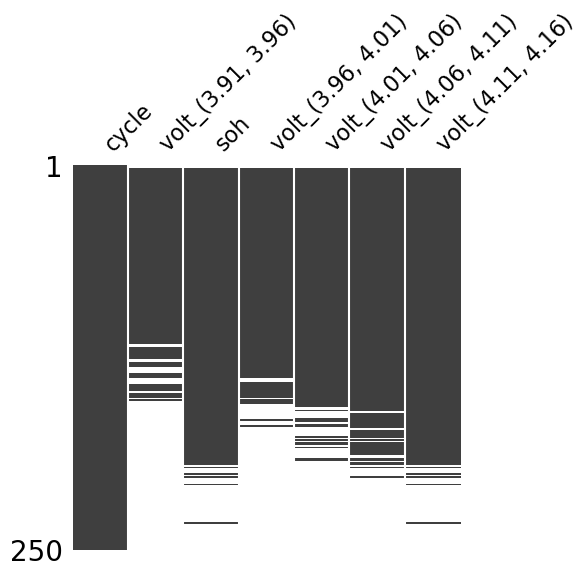

In [60]:
msno.matrix(df_time_diff, sparkline=False, figsize=(5, 5))

In [62]:
df_time_diff_final = df_time_diff.dropna()

In [64]:
df_time_diff_final.head()

,cycle,"volt_(3.91, 3.96)",soh,"volt_(3.96, 4.01)","volt_(4.01, 4.06)","volt_(4.06, 4.11)","volt_(4.11, 4.16)"
2,2,840.427828,0.0,720.369000,570.288087,480.244365,420.214257
3,3,780.377010,0.0,750.378730,600.303152,510.257500,420.211978
4,4,720.363287,0.0,750.378437,630.317934,540.272595,450.227322
5,5,720.365250,1.0,750.383193,600.302030,480.243691,450.228407
6,6,750.381141,1.0,720.365705,600.304863,510.259132,450.228654


In [66]:
df_time_diff_final.describe()

,cycle,"volt_(3.91, 3.96)",soh,"volt_(3.96, 4.01)","volt_(4.01, 4.06)","volt_(4.06, 4.11)","volt_(4.11, 4.16)"
count,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000
mean,71.204380,346.597212,0.978102,447.158013,471.257640,435.984665,400.273608
std,41.651943,168.536620,0.146887,169.879802,129.273037,80.906477,50.208708
min,2.000000,90.045150,0.000000,150.073293,210.090237,240.120842,270.135764
25%,36.000000,180.090868,1.000000,300.151204,390.194209,390.196327,390.180213
50%,70.000000,390.196381,1.000000,510.256977,540.271953,480.241816,420.211694
75%,104.000000,450.227115,1.000000,570.287659,570.287602,510.241639,450.211179
max,152.000000,840.427828,1.000000,750.383193,630.319561,540.274392,450.229083


In [68]:
df_time_diff_final.to_csv('C:/Users/gorob/CS2_33/df_time_diff_final.csv', index = False)

In [70]:
train, test, y_train, y_test = train_test_split(
    df_time_diff_final.drop(['soh'], axis=1), 
    df_time_diff_final['soh'], 
    test_size=.3, 
    stratify=df_time_diff_final['soh'], 
    random_state=100)

In [2]:
def define_voltage(train, y_train, imp_strategy):
    train_copy = train.copy()
    auc_ = []
    columns = train_copy.columns.difference(['cycle'])
    for i in columns:
        pipe = Pipeline([
            ('imputer', SimpleImputer(strategy=imp_strategy)),
            ('scaler', StandardScaler()), 
            ('logreg', LogisticRegression(solver='liblinear'))
        ])
        auc = cross_val_score(pipe, train_copy[[i]], y_train, scoring='roc_auc', cv=2).mean()
        auc_.append(auc)
    result = pd.DataFrame({'Змінна': columns,'AUC': auc_})
    result = np.round(result.sort_values(by='AUC', ascending=False),2)
    cm = sns.light_palette('blue', as_cmap=True)
    return (result.style.background_gradient(cmap=cm))

define_voltage(train, y_train, 'median')

NameError: name 'train' is not defined